In [162]:
import pandas as pd
import numpy as np

In [163]:
# Load the distance matrix
df = pd.read_csv('Similarity-matrix-species.csv', index_col=0)
distance_matrix = df.to_numpy()
similarity_matrix = 1 - distance_matrix / distance_matrix.max()

# Apply softmax to the similarity matrix
similarity_matrix = similarity_matrix ** 1

species_index = np.array(df.index.tolist())

episodes_size = [20, 20, 20]
n_states = np.sum(episodes_size)

species = np.random.choice(np.arange(len(species_index)), size=n_states)  

times = np.arange(0, n_states)
times = 1 - times / times.max()

episodes = np.repeat(np.arange(len(episodes_size)), episodes_size)

# Create the data frame
df = pd.DataFrame({'species': species, 'time': times, 'episode': episodes})
states = df.to_numpy()

In [164]:
from environments_episodic import EpisodicGraph
from generators import Generator
from propagators import Propagator
from simulators_episodic import EpisodicSimulator 

# Create the environment
k = 1  # Connectivity
m = 5  # Similarity
n = 0  # Time
env = EpisodicGraph(states, similarity_matrix, k=k, m=m, n=n)

# Create the generator
generator = Generator(env)

# Create the propagator
propagator = Propagator(generator)

# Create the simulator
init_state = 5
simulator = EpisodicSimulator(propagator, init_state)

# Simulate
n_step = 50
n_samp = 20
simulator.sample_sequences(n_step=n_step, n_samp=n_samp)

seqs = simulator.state_seqs
print(seqs)

seqs_dummy = np.arange(0, n_step if n_step < n_states else n_states).reshape(1, -1)

GENERATOR: generator constructed from environment transition matrix with jump_rate 15.00
GENERATOR: matrix rows sum to 0.
GENERATOR: generator is not symmetric.
GENERATOR: Q is a generator with shape (60, 60) .
EIGENSPECTRUM: algebraic multiplicity of zero eigenvalue = 1
EIGENSPECTRUM: algebraic multiplicity > 1.
[[ 5 21  9 ... 33 54 26]
 [ 5 54 29 ... 15  1 41]
 [ 5 41 52 ... 50 22 48]
 ...
 [ 5 42 34 ... 20 27  3]
 [ 5 46 23 ...  5 59  4]
 [ 5 18 22 ... 22  6 22]]


In [165]:
def create_df_sequences(seqs):
    df_sequences = pd.DataFrame()
    for i in range(seqs.shape[0]):
        data = states[seqs[i, :]]
        species_i = np.array(data[:, 0], dtype=int)
        species_i = [species_index[ii] for ii in species_i]
        times_i = (1 - data[:, 1]) * (n_states - 1)
        episodes_i = np.array(data[:, 2], dtype=int)

        df_i = pd.DataFrame({'species': species_i, 'time': times_i, 'episode': episodes_i})

        # Append a column with the sequence number
        df_i["seq"] = i

        df_sequences = df_sequences.append(df_i, ignore_index=True)
    return df_sequences

In [166]:
# Create a pandas dataframe with the states sequence
df_sequences = create_df_sequences(seqs)
df_sequences_dummy = create_df_sequences(seqs_dummy)

df_sequences_dummy["seq"] = "dummy"

df_sequences = df_sequences.append(df_sequences_dummy, ignore_index=True)

# Create a pandas dataframe with the states
species_i = np.array(states[:, 0], dtype=int)
species_i = [species_index[ii] for ii in species_i]
times_i = (1 - states[:, 1]) * (n_states - 1)
episodes_i = np.array(states[:, 2], dtype=int)

df_states = pd.DataFrame({'species': species_i, 'time': times_i, 'episode': episodes_i})

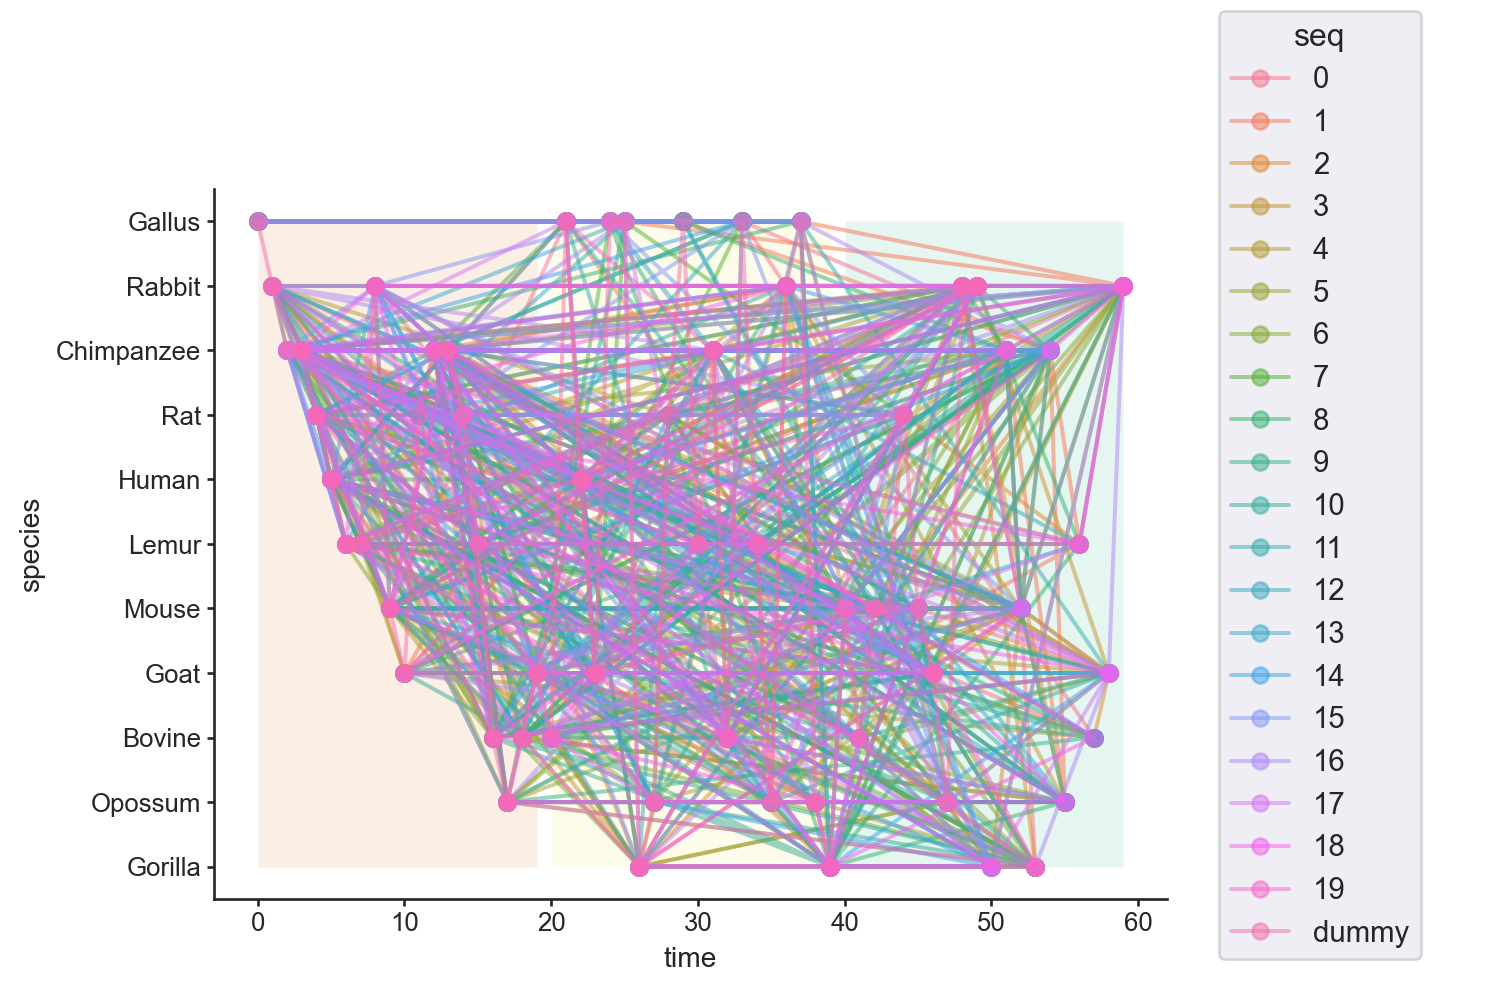

In [167]:
import seaborn.objects as so
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig, ax = plt.subplots()

i_prev = 0
colors = ["r", "y", "g"]
for c, i in zip(colors, episodes_size):
    rect = Rectangle((i_prev, 0), i - 1, len(species_index) - 1, linewidth=1, facecolor=c, alpha=0.1)
    ax.add_patch(rect)
    i_prev += i

(
    so.Plot(df_states, x="time", y="species")
    .add(so.Dot(color="k", alpha=0.1))
    .on(ax)
    .plot()
)

(
    so.Plot(df_sequences, x="time", y="species", color="seq")
    .add(so.Path(marker="o", alpha=0.5))
    .scale(color=so.Nominal())
    .on(ax)
    .plot()
)



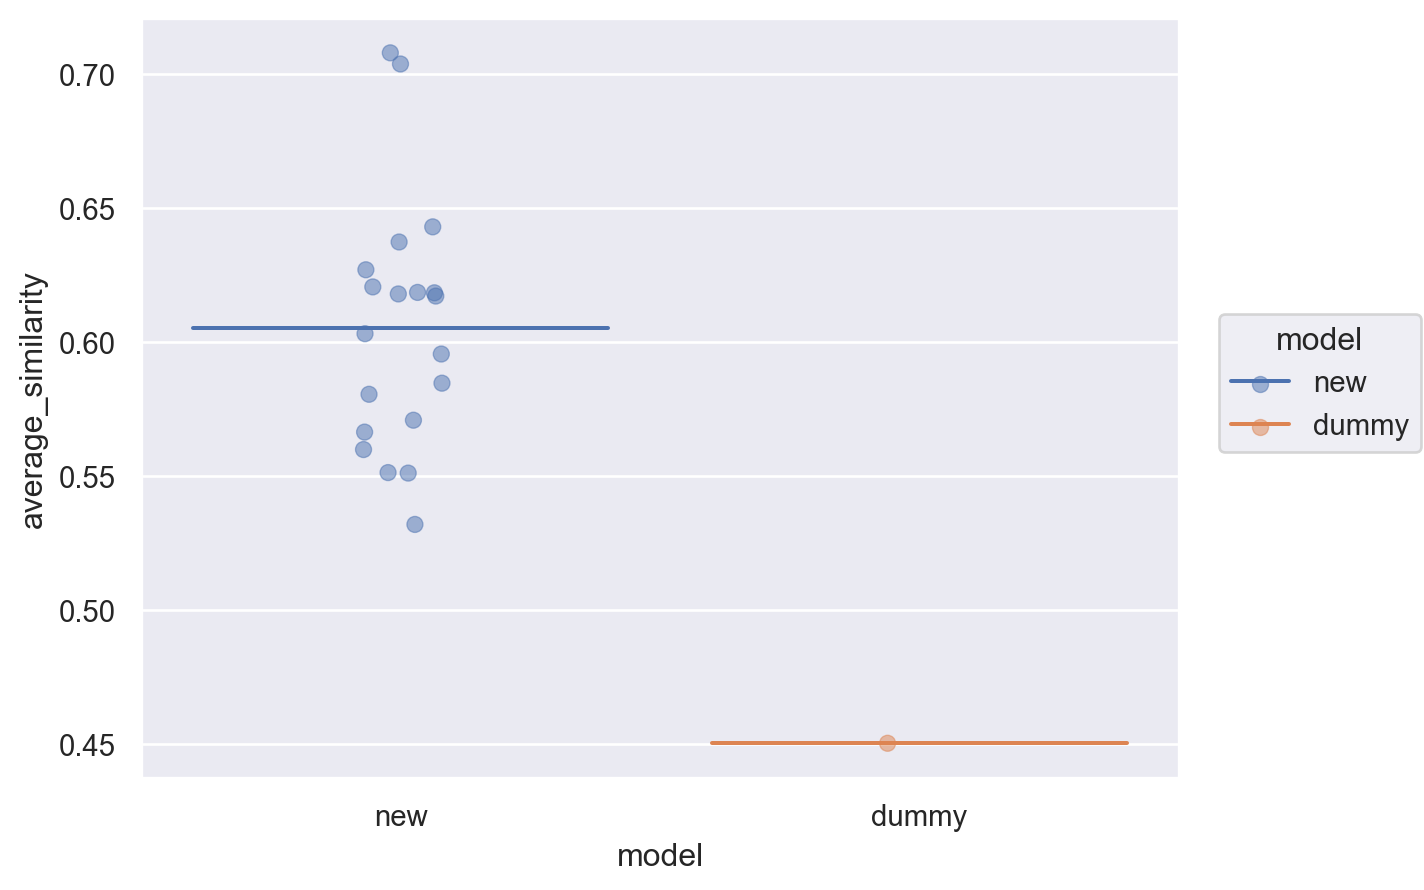

In [168]:
import seaborn.objects as so

def average_similarity(seqs):
    w1 = np.array(states[seqs[:, 1:]][:, :, 0], dtype=int)
    w2 = np.array(states[seqs[:, :-1]][:, :, 0], dtype=int)
    d = similarity_matrix[w1, w2]
    return d.mean(axis=1)

a_sim = average_similarity(seqs)

df_sim = pd.DataFrame({'average_similarity': a_sim, 'model': 'new'})

a_sim_dummy = average_similarity(seqs_dummy)
df_sim_dummy = pd.DataFrame({'average_similarity': a_sim_dummy, 'model': 'dummy'})

df_sim = df_sim.append(df_sim_dummy, ignore_index=True)

(
    so.Plot(df_sim, x="model", color="model", y="average_similarity")
    .add(so.Dot(alpha=.5), so.Jitter())
    .add(so.Dash(), so.Agg())
)
